In [1]:
import pandas
from geosnap import Community
from geosnap import datasets
import fiona
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt
import segregation
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

# questions for today 5/27
# bucket problem with geosnap?
# losing district and county name with frpm aggregation
# merge operation breaking ela currstatus 

C:\Users\fiend\Anaconda2\envs\capstone\lib\site-packages\geosnap\_data.py:123: UserWarning: Unable to locate local census data. Streaming instead.
If you plan to use census data repeatedly you can store it locally with the io.store_census function for better performance
  "Unable to locate local census data. Streaming instead.\n"
Loading manifest: 100%|██████████| 5/5 [00:00<?, ?entries/s]
C:\Users\fiend\Anaconda2\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.spectral module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_column', 500)

In [3]:
ele = geopandas.read_file("districts_tiger/tl_2015_us_sde.shp")
# Reading in shapefiles from census/tiger

In [4]:
seco = geopandas.read_file("districts_tiger/tl_2015_us_sds.shp")

In [5]:
uni = geopandas.read_file("districts_tiger/tl_2015_us_sdu.shp")

In [6]:
ele = ele.loc[ele['STATEFP'] == '06']
# slicing out California
# elementary school districts in California

In [7]:
seco = seco.loc[seco['STATEFP'] == '06']
# secondary school districts in California

In [8]:
uni = uni.loc[uni['STATEFP'] == '06']
# unified school districts in California

In [9]:
len(ele)+len(seco)+len(uni)

986

## Combining shapefiles into single geodataframe

In [10]:
ele['origin'] = 'elementary'

In [11]:
seco['origin'] = 'secondary'

In [12]:
uni['origin'] = 'unified'

In [13]:
adistricts = uni.append([ele, seco])
#all districts

In [14]:
adistricts = adistricts.sort_values('NAME', ascending=True)

In [15]:
adistricts['NAME'] = adistricts['NAME'].str.replace('School District', '')
adistricts['NAME'] = adistricts['NAME'].str.strip()

In [16]:
check = adistricts['NAME'].str.contains('County Office')
res = [i for i, val in enumerate(check) if val]
print(res)

[]


In [17]:
cnames = (
'Alameda County', 
'Alpine County', 
'Amador County', 
'Butte County', 
'Calaveras County', 
'Colusa County', 
'Contra Costa County',
'Del Norte County', 
'El Dorado County', 
'Fresno County', 
'Glenn County',
'Humboldt County',
'Imperial County', 
'Inyo County',
'Kern County', 
'Kings County',
'Lake County', 
'Lassen County',
'Los Angeles County', 
'Madera County', 
'Marin County', 
'Mariposa County', 
'Mendocino County', 
'Merced County', 
'Modoc County', 
'Mono County', 
'Monterey County', 
'Napa County', 
'Nevada County', 
'Orange County',
'Placer County',
'Plumas County', 
'Riverside County', 
'Sacramento County', 
'San Benito County', 
'San Bernardino County', 
'San Diego County', 
'San Francisco County', 
'San Joaquin County', 
'San Luis Obispo County',
'San Mateo County',
'Santa Barbara County', 
'Santa Clara County',
'Santa Cruz County', 
'Shasta County', 
'Sierra County', 
'Siskiyou County', 
'Solano County', 
'Sonoma County',
'Stanislaus County', 
'Sutter County', 
'Tehama County',
'Trinity County', 
'Tulare County', 
'Tuolumne County', 
'Ventura County', 
'Yolo County',
'Yuba County')

In [18]:
geoid = ('06001',
'06003',
'06005',
'06007',
'06009',
'06011',
'06013',
'06015',
'06017',
'06019',
'06021',
'06023',
'06025',
'06027',
'06029',
'06031',
'06033',
'06035',
'06037',
'06039',
'06041',
'06043',
'06045',
'06047',
'06049',
'06051',
'06053',
'06055',
'06057',
'06059',
'06061',
'06063',
'06065',
'06067',
'06069',
'06071',
'06073',
'06075',
'06077',
'06079',
'06081',
'06083',
'06085',
'06087',
'06089',
'06091',
'06093',
'06095',
'06097',
'06099',
'06101',
'06103',
'06105',
'06107',
'06109',
'06111',
'06113', 
'06115')

In [19]:
cfips = pandas.DataFrame(zip(cnames, geoid), columns=['county_name', 'GEOID'])
cfips['county_name'] = cfips['county_name'].str.replace('County', '')
# stripping white space
cfips.head()

,county_name,GEOID
0,Alameda,06001
1,Alpine,06003
2,Amador,06005
3,Butte,06007
4,Calaveras,06009


In [20]:
adistricts.shape

(986, 18)

In [21]:
adsgeo = adistricts['NAME']
# all districs name list

In [22]:
adsgeo.unique().shape
# todo: some districts listed twice

(970,)

In [23]:
dupes = adistricts[adistricts['NAME'].isin(adistricts['NAME'].value_counts()[adistricts['NAME'].value_counts()>2].index)]
dupes['NAME'] = dupes['NAME'].str.strip()
print(dupes['NAME'].unique())
# 3 Jefferson
# 3 Lakeside
# 3 Pioneer

# create new column indicating countyID

['Jefferson Elementary' 'Lakeside Union Elementary'
 'Pioneer Union Elementary']


C:\Users\fiend\Anaconda2\envs\capstone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Harmonizing data

ela + math `currstatus` Average distance from Standard of students who took the Smarter Balanced summative assessment in ela/math


options<br>
* questions of differences across groups? (no geography)
* differences across districts (group by district)
* differences across groups in districts (interaction effects > more pronounced differences in certain districts)

visualization

* what is the best indicator to use for choropleth ()

* or - use state level values as benchmark for each group (how is it reflected in each district, heterogeniety in space?)

## ELA acheivement indicator data
Find the codebook [here](https://www.cde.ca.gov/ta/ac/cm/ela18.asp)

In [24]:
ela = pandas.read_csv('lcff_data/eladownload2018.csv')
ela.shape

C:\Users\fiend\Anaconda2\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(148838, 32)

In [25]:
ela.head()

,cds,rtype,schoolname,districtname,countyname,charter_flag,coe_flag,dass_flag,studentgroup,currdenom,currdenom_swd,currstatus,priordenom,priordenom_swd,priorstatus,change,statuslevel,changelevel,color,box,hscutpoints,curradjustment,prioradjustment,pairshare_method,caa_denom,caa_level1_num,caa_level1_pct,caa_level2_num,caa_level2_pct,caa_level3_num,caa_level3_pct,ReportingYear
0,0,X,NaN,NaN,NaN,NaN,NaN,NaN,AA,172224,NaN,-51.8,177009.0,NaN,-52.7,0.9,2,3,2,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,0,X,NaN,NaN,NaN,NaN,NaN,NaN,AI,16662,NaN,-36.8,17234.0,NaN,-39.1,2.3,2,3,2,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2,0,X,NaN,NaN,NaN,NaN,NaN,NaN,ALL,3171704,NaN,-6.0,3200441.0,NaN,-8.2,2.2,2,3,2,180,NaN,NaN,NaN,NaN,36140.0,18581.0,51.4,11330.0,31.4,6229.0,17.2,2018
3,0,X,NaN,NaN,NaN,NaN,NaN,NaN,AS,293002,NaN,62.4,295040.0,NaN,60.5,2.0,5,3,5,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4,0,X,NaN,NaN,NaN,NaN,NaN,NaN,EL,1000703,NaN,-47.1,1021418.0,NaN,-50.4,3.3,2,4,3,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


## Creating state-level variable

In [26]:
replacements = dict(
    studentgroup = {'ALL':'all_students',
                        'AA':'african_american',
                        'AI':'american_indian',
                        'AS':'asian',
                        'FI':'filipino',
                        'HI':'hispanic',
                        'PI':'pacific_islander',
                        'WH':'white',
                        'MR':'multiple_races',
                        'EL':'english_learners',
                        'ELO':'english_learners_only',
                        'RFP':'rfep_only',
                        'EO':'english_only',
                        'SED':'ses_disad',
                        'SWD':'disabilities',
                        'FOS':'foster_youth',
                        'HOM':'homeless_youth',
                })
# dictionary for replacing acronyms, reuse later

ela['studentgroup'].astype(str)
ela = ela.replace(replacements)
# replace acronyms

j = ela
j = j.loc[j['rtype'] == 'X']
# select by no-type (state)
k = pandas.concat([j.pop(x) for x in ['studentgroup', 
                                      'currstatus', 
                                      'priorstatus', 
                                      'change',
                                      'currdenom']],
                  1)
# slice out columns
ela_state = k.sort_values(by='currstatus', ascending=False)
# state-level ela performance variable

## Aggregation 

In [27]:
# fixing cds codes to match with other datasets
ela['cds'].astype(str)
# changing cds code to string
ela = ela[ela.coe_flag !='Y']
# removing county offices of education
ela = ela.loc[ela['rtype'] == 'D']
# select district level entries
ela['cds'] = ela['cds'].apply(lambda x: '{0:0>14}'.format(x))
# adding leading zero to 13 digit int
ela['District Code'] = [x[2:7] for x in ela['cds']]
# adding district only code
elat = set(ela['cds'])
# creating test set variable
ela.head()

,cds,rtype,schoolname,districtname,countyname,charter_flag,coe_flag,dass_flag,studentgroup,currdenom,currdenom_swd,currstatus,priordenom,priordenom_swd,priorstatus,change,statuslevel,changelevel,color,box,hscutpoints,curradjustment,prioradjustment,pairshare_method,caa_denom,caa_level1_num,caa_level1_pct,caa_level2_num,caa_level2_pct,caa_level3_num,caa_level3_pct,ReportingYear,District Code
164,01611190000000,D,NaN,Alameda Unified,Alameda,NaN,NaN,NaN,african_american,298,NaN,-43.0,332.0,NaN,-48.7,5.7,2,4,3,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,61119
165,01611190000000,D,NaN,Alameda Unified,Alameda,NaN,NaN,NaN,american_indian,13,NaN,-14.8,14.0,NaN,14.3,-29.1,2,1,0,0,NaN,NaN,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,61119
166,01611190000000,D,NaN,Alameda Unified,Alameda,NaN,NaN,NaN,all_students,4550,NaN,36.8,4541.0,NaN,32.8,4.0,4,4,4,90,NaN,NaN,NaN,NaN,38.0,26.0,68.4,6.0,15.8,6.0,15.8,2018,61119
167,01611190000000,D,NaN,Alameda Unified,Alameda,NaN,NaN,NaN,asian,1288,NaN,48.6,1334.0,NaN,54.0,-5.3,5,2,4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,61119
168,01611190000000,D,NaN,Alameda Unified,Alameda,NaN,NaN,NaN,english_learners,1084,NaN,-2.5,1176.0,NaN,-1.4,-1.1,3,3,3,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,61119


In [28]:
#creating district-level ela performance variable (dictionary)
dfe = ela
dfe = pandas.concat([dfe.pop(x) for x in ['District Code',
                                          'districtname',                                          
                                          'studentgroup', 
                                          'currstatus', 
                                          'priorstatus', 
                                          'change',
                                          'countyname']],
                    1)
# slice out columns

## Math achievement indicator data
find the codebook [here](https://www.cde.ca.gov/ta/ac/cm/math18.asp)

In [29]:
math = pandas.read_csv('lcff_data/mathdownload2018.csv')
math.shape

C:\Users\fiend\Anaconda2\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(148705, 32)

In [30]:
math

,cds,rtype,schoolname,districtname,countyname,charter_flag,coe_flag,dass_flag,studentgroup,currdenom,currdenom_swd,currstatus,priordenom,priordenom_swd,priorstatus,change,statuslevel,changelevel,color,box,hscutpoints,curradjustment,prioradjustment,pairshare_method,caa_denom,caa_level1_num,caa_level1_pct,caa_level2_num,caa_level2_pct,caa_level3_num,caa_level3_pct,ReportingYear
0,0,X,NaN,NaN,NaN,NaN,NaN,NaN,AA,171493,NaN,-91.5,176285.0,NaN,-91.6,0.2,2,3,2,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,0,X,NaN,NaN,NaN,NaN,NaN,NaN,AI,16622,NaN,-73.0,17167.0,NaN,-72.3,-0.7,2,3,2,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2,0,X,NaN,NaN,NaN,NaN,NaN,NaN,ALL,3166345,NaN,-36.4,3195814.0,NaN,-37.7,1.3,2,3,2,180,NaN,NaN,NaN,NaN,36002.0,23217.0,64.5,9948.0,27.6,2837.0,7.9,2018
3,0,X,NaN,NaN,NaN,NaN,NaN,NaN,AS,293068,NaN,56.7,295229.0,NaN,54.3,2.4,5,3,5,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4,0,X,NaN,NaN,NaN,NaN,NaN,NaN,EL,999887,NaN,-69.9,1020711.0,NaN,-71.4,1.5,2,3,2,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148700,58727695838305,S,Wheatland Union High,Wheatland Union High,Yuba,NaN,NaN,NaN,PI,1,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
148701,58727695838305,S,Wheatland Union High,Wheatland Union High,Yuba,NaN,NaN,NaN,RFP,2,NaN,NaN,3.0,NaN,NaN,NaN,0,0,0,0,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
148702,58727695838305,S,Wheatland Union High,Wheatland Union High,Yuba,NaN,NaN,NaN,SED,67,NaN,-90.0,54.0,NaN,-72.8,-17.2,2,1,2,160,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
148703,58727695838305,S,Wheatland Union High,Wheatland Union High,Yuba,NaN,NaN,NaN,SWD,17,17.0,-225.9,9.0,9.0,NaN,NaN,1,0,0,0,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [31]:
math['studentgroup'].astype(str)
math = math.replace(replacements)
# replace codes
p = math
p = p.loc[p['rtype'] == 'X']
# select by no-type (state)
q = pandas.concat([p.pop(x) for x in ['studentgroup', 
                                      'currstatus', 
                                      'priorstatus', 
                                      'change',
                                      'currdenom']],
                  1)
# slice out columns
math_state = q.sort_values(by='currstatus', ascending=False)


## Aggregation

In [32]:
# fixing cds codes to match with other datasets
math['cds'].astype(str)
# changing to string
math = math[math.coe_flag !='Y']
# removing county offices of education
math = math.loc[math['rtype'] == 'D']
# select district level performance
math['cds'] = math['cds'].apply(lambda x: '{0:0>14}'.format(x))
# adding leading zero to 13 digit int
math['District Code'] = [x[2:7] for x in math['cds']]
# adding district only code

In [33]:
#creating district-level math performance variable (dictionary)
dfm = math
dfm = pandas.concat([dfm.pop(x) for x in ['District Code',
                                          'districtname',                                          
                                          'studentgroup', 
                                          'currstatus', 
                                          'priorstatus', 
                                          'change',
                                          'countyname']],
                    1)
# slice out columns

In [34]:
dfm

,District Code,districtname,studentgroup,currstatus,priorstatus,change,countyname
163,61119,Alameda Unified,african_american,-83.9,-82.8,-1.1,Alameda
164,61119,Alameda Unified,american_indian,-51.8,-50.0,-1.8,Alameda
165,61119,Alameda Unified,all_students,14.3,10.8,3.4,Alameda
166,61119,Alameda Unified,asian,43.6,44.8,-1.2,Alameda
167,61119,Alameda Unified,english_learners,-13.7,-12.9,-0.9,Alameda
...,...,...,...,...,...,...,...
148683,72769,Wheatland Union High,pacific_islander,NaN,NaN,NaN,Yuba
148684,72769,Wheatland Union High,rfep_only,NaN,NaN,NaN,Yuba
148685,72769,Wheatland Union High,ses_disad,-90.0,-74.0,-16.0,Yuba
148686,72769,Wheatland Union High,disabilities,-226.6,NaN,NaN,Yuba


# LCFF funding data

[FAQ here](https://www.cde.ca.gov/fg/aa/lc/lcfffaq.asp#CALPADS)

In [35]:
lcff = pandas.read_csv('lcff_data/lcffsnapshot18an.csv')
lcff.shape

(2243, 26)

In [36]:
lcff.columns
# leading AND trailing spaces! inconsistently!! 

Index([' County Code ', 'District Code', 'School Code',
       'Local Educational Agency ', 'Charter Number',
       ' TK/K-3 ADA\nTarget, B-5/B-1 ', ' 4 - 6 ADA\nTarget, B-6/B-2 ',
       ' 7 - 8 ADA\nTarget, B-7/B-3 ', ' 9 - 12 ADA\nTarget, B-8/B-4 ',
       'Unduplicated Pupil Percentage\nTarget, D-1',
       ' Base Grant Funding\nTarget, C-5 ',
       ' Supplemental Grant Funding\nTarget, D-7 ',
       ' Concentration Grant Funding\nTarget, E-8 ',
       ' Necessary Small Schools Allowance\nTarget, F-1 ',
       ' Add-On (Based on 2012-13 Targeted Instructional Improvement Block Grant)\nTarget, F-2 ',
       ' Add-On (Based on 2012-13 Home-to-School Transportation)\nTarget, F-3 ',
       ' Add-On (Based on 2012-13 Small School District Bus Replacement Program)\nTarget, F-4 ',
       ' Total LCFF Target Entitlement\nTarget, G-1/F-1 ',
       ' Total LCFF Floor Entitlement\nTransition, B-13 ',
       ' Current Year Gap Funding (100%)\nTransition, C-3 ',
       ' Economic Recovery Tar

In [37]:
lcff.columns = lcff.columns.str.strip()
# strip leading/trailing spaces

In [38]:
lcff_state_totals = lcff.tail(1)
lcff.drop(lcff.tail(1).index,inplace=True)
# extracting state totals, removing from df

In [39]:
# Slicing by district level cds code
lcff['County Code'] = lcff['County Code'].astype(str)
lcff['District Code'] = lcff['District Code'].astype(int)
lcff['District Code'] = lcff['District Code'].astype(str)
lcff['School Code'] = lcff['School Code'].astype(int)
lcff['School Code'] = lcff['School Code'].astype(str)
# Changing to strings
lcff['School Code'] = lcff['School Code'].apply(lambda x: '{0:0>7}'.format(x))
# Front fill school codes to == 7
lcff = lcff.loc[lcff['School Code'] == '0000000']
# select districts, district entries do not have a school level cds code
lcff['cds'] = lcff['County Code'] + lcff['District Code'] + lcff['School Code']
# Combining into cds code
col_name='cds'
first_col = lcff.pop(col_name)
lcff.insert(0, col_name, first_col)
# Moving to front 
lcff.drop('County Code', axis=1, inplace=True)
# lcff.drop('District Code', axis=1, inplace=True)
lcff.drop('School Code', axis=1, inplace=True)
len(lcff)

944

In [40]:
# renaming important columns
lcff = lcff.rename(columns={'Charter Number': 'charter_number',
                     'Unduplicated Pupil Percentage\nTarget, D-1': 'unduplicated_pupil_percentage',
                     'Base Grant Funding\nTarget, C-5': 'base_grant',
                     'Supplemental Grant Funding\nTarget, D-7': 'supplemental_grant',
                     'Concentration Grant Funding\nTarget, E-8': 'concentration_grant',
                     'Total LCFF Target Entitlement\nTarget, G-1/F-1': 'total_grants',
                     'Unduplicated Pupil Percentage\nTarget, D-1': 'unduplicated_pupil_count',
                     'Necessary Small Schools Allowance\nTarget, F-1': 'nec_small_schools'
                           })

In [41]:
lcff.head()
# cds codes are now concurrent with documentation and comparable to acheivement data

,cds,District Code,Local Educational Agency,charter_number,"TK/K-3 ADA\nTarget, B-5/B-1","4 - 6 ADA\nTarget, B-6/B-2","7 - 8 ADA\nTarget, B-7/B-3","9 - 12 ADA\nTarget, B-8/B-4",unduplicated_pupil_count,base_grant,supplemental_grant,concentration_grant,nec_small_schools,"Add-On (Based on 2012-13 Targeted Instructional Improvement Block Grant)\nTarget, F-2","Add-On (Based on 2012-13 Home-to-School Transportation)\nTarget, F-3","Add-On (Based on 2012-13 Small School District Bus Replacement Program)\nTarget, F-4",total_grants,"Total LCFF Floor Entitlement\nTransition, B-13","Current Year Gap Funding (100%)\nTransition, C-3","Economic Recovery Target\nTransition, D-1","Miscellaneous Adjustments\nTransition, E-1","Total Local Revenue or In-Lieu of Property Taxes\nTransition, F-2/F-7","Education Protection Account Entitlement\nTransition, F-5/F-9","Net State Aid\nTransition, F-6/F-10","Additional SA for MSA Guarantee\nTransition, H-1/H-2"
10,01611190000000,61119,Alameda Unified,NaN,"2,870.43","1,917.91","1,219.66","3,050.17",0.3486,"75,938,983","5,294,466",-,-,"665,778","258,889",-,"82,158,116","77,176,229","4,981,887",-,-,"29,277,891","14,772,333","38,107,892",-
16,01611270000000,61127,Albany City Unified,NaN,"1,060.09",806.37,554.25,"1,131.64",0.2833,"29,644,972","1,679,684",-,-,-,"27,884",-,"31,352,540","29,460,891","1,891,649",-,-,"11,005,115","5,777,202","14,570,223",-
17,01611430000000,61143,Berkeley Unified,NaN,"2,828.54","2,101.08","1,397.55","3,070.55",0.3519,"78,556,532","5,528,808",-,-,"4,293,233","991,048",-,"89,369,621","84,726,528","4,643,093","820,253",-,"43,425,650","8,875,387","37,888,837",-
19,01611500000000,61150,Castro Valley Unified,NaN,"2,617.44","2,032.50","1,400.40","2,918.48",0.2904,"74,911,585","4,350,864",-,-,-,"292,158",-,"79,554,607","74,489,641","5,064,966",-,-,"26,572,525","14,660,230","38,321,852",-
20,01611680000000,61168,Emery Unified,NaN,237.65,151.54,104.99,191.97,0.7953,"5,702,229","906,997","699,378",-,-,"18,271",-,"7,326,875","6,698,947","627,928","108,723",-,"5,582,328","137,230","1,716,040",-


In [42]:
#is this done?
dflcff = lcff[['District Code', 'Local Educational Agency', 'unduplicated_pupil_count', 'base_grant', 'supplemental_grant', 'concentration_grant', 'total_grants', 'cds' ]].copy()
dflcff.shape

(944, 8)

## LCFF geodataframe + mapping

In [43]:
a1 = pandas.merge(dflcff, adistricts, how='left', left_on='Local Educational Agency', right_on='NAME')
a1.head()

,District Code,Local Educational Agency,unduplicated_pupil_count,base_grant,supplemental_grant,concentration_grant,total_grants,cds,STATEFP,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,origin,ELSDLEA,SCSDLEA
0,61119,Alameda Unified,0.3486,"75,938,983","5,294,466",-,"82,158,116",01611190000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
1,61127,Albany City Unified,0.2833,"29,644,972","1,679,684",-,"31,352,540",01611270000000,06,01860,0601860,Albany City Unified,00,KG,12,G5420,None,E,4634305.0,9523833.0,+37.8906499,-122.3181164,"POLYGON ((-122.37312 37.88388, -122.37114 37.8...",unified,NaN,NaN
2,61143,Berkeley Unified,0.3519,"78,556,532","5,528,808",-,"89,369,621",01611430000000,06,04740,0604740,Berkeley Unified,00,KG,12,G5420,None,E,27095285.0,18715614.0,+37.8669717,-122.2991474,"POLYGON ((-122.36778 37.86673, -122.35671 37.8...",unified,NaN,NaN
3,61150,Castro Valley Unified,0.2904,"74,911,585","4,350,864",-,"79,554,607",01611500000000,06,07800,0607800,Castro Valley Unified,00,KG,12,G5420,None,E,177385526.0,4276387.0,+37.7196716,-122.0463454,"POLYGON ((-122.17916 37.80498, -122.17914 37.8...",unified,NaN,NaN
4,61168,Emery Unified,0.7953,"5,702,229","906,997","699,378","7,326,875",01611680000000,06,12630,0612630,Emery Unified,00,KG,12,G5420,None,E,3317306.0,2517858.0,+37.8399065,-122.2989635,"POLYGON ((-122.33014 37.84111, -122.32432 37.8...",unified,NaN,NaN


In [44]:
a1.shape

(974, 26)

In [45]:
a1 = geopandas.GeoDataFrame(a1)

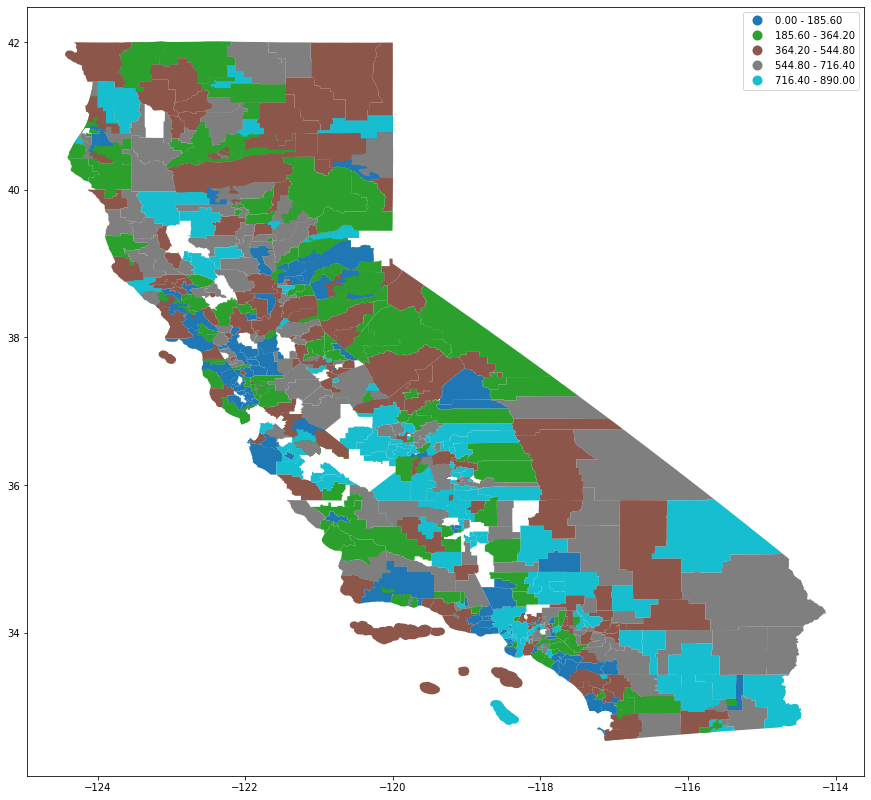

In [46]:
a1.plot(
    column='unduplicated_pupil_count',
    legend=True,
    figsize=(15, 15),
    scheme="quantiles"
        )

# Free and reduced meal plan data
Used by policy makers as a stand-in for a  segregation indicator. 

Find the codebook [here](https://www.cde.ca.gov/ds/sd/sd/fsspfrpm.asp).

In [47]:
frpm = pandas.read_csv('lcff_data/frpm1819.csv', encoding = "ISO-8859-1", skiprows=1)
frpm.shape
# aggregate figures by district
# jump down to 'mealagg' cell

(10520, 28)

In [48]:
# renaming important columns
frpm = frpm.rename(columns={'Percent (%) \nEligible FRPM \n(K-12)': 'percent_eligible_k12_frpm', 
                            'Percent (%) \nEligible Free \n(K-12)': 'percent_eligible_k12_free', 
                            'Percent (%) \nEligible FRPM \n(Ages 5-17)' : 'percent_eligible_by_age',
                            'Enrollment \n(Ages 5-17)': 'enrollment_by_age',
                            'FRPM Count \n(Ages 5-17)': 'frpm_count_by_age',
                            'Free Meal \nCount \n(Ages 5-17)': 'free_count_by_age',
                            'District Type': 'district_type',
                            'District Name': 'district_name',
                            'County Name': 'county_name',
                            
                           })

In [49]:
frpm.head()

,Academic Year,County Code,District Code,School Code,county_name,district_name,School Name,district_type,School Type,Educational \nOption Type,NSLP \nProvision \nStatus,Charter \nSchool \n(Y/N),Charter \nSchool \nNumber,Charter \nFunding \nType,IRC,Low Grade,High Grade,Enrollment \n(K-12),Free Meal \nCount \n(K-12),percent_eligible_k12_free,FRPM Count \n(K-12),percent_eligible_k12_frpm,enrollment_by_age,free_count_by_age,Percent (%) \nEligible Free \n(Ages 5-17),frpm_count_by_age,percent_eligible_by_age,CALPADS Fall 1 \nCertification Status
0,2018-2019,1,10017,112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,County Office of Education (COE),High Schools (Public),Traditional,NaN,Yes,0811,Directly funded,Y,9,12,385,262,68.1%,306,79.5%,370,249,67.3%,291,78.6%,Y
1,2018-2019,1,10017,123968,Alameda,Alameda County Office of Education,Community School for Creative Education,County Office of Education (COE),Elementary Schools (Public),Traditional,NaN,Yes,1284,Directly funded,Y,K,8,241,118,49.0%,120,49.8%,224,113,50.4%,115,51.3%,Y
2,2018-2019,1,10017,124172,Alameda,Alameda County Office of Education,Yu Ming Charter,County Office of Education (COE),Elementary Schools (Public),Traditional,NaN,Yes,1296,Directly funded,Y,K,8,445,58,13.0%,64,14.4%,445,58,13.0%,64,14.4%,Y
3,2018-2019,1,10017,125567,Alameda,Alameda County Office of Education,Urban Montessori Charter,County Office of Education (COE),Elementary Schools (Public),Traditional,NaN,Yes,1383,Directly funded,Y,K,8,432,113,26.2%,131,30.3%,418,111,26.6%,129,30.9%,Y
4,2018-2019,1,10017,130401,Alameda,Alameda County Office of Education,Alameda County Juvenile Hall/Court,County Office of Education (COE),Juvenile Court Schools,Juvenile Court School,NaN,No,NaN,NaN,N,K,12,53,53,100.0%,53,100.0%,50,50,100.0%,50,100.0%,Y


In [50]:
#creating CDS code
frpm['County Code'] = frpm['County Code'].astype(str)
frpm['County Code'] = frpm['County Code'].apply(lambda x: '{0:0>2}'.format(x))
frpm['District Code'] = frpm['District Code'].astype(str)
frpm['School Code'] = frpm['School Code'].astype(str)
frpm['School Code'] = frpm['School Code'].apply(lambda x: '{0:0>7}'.format(x))
# converting to strings, adding leading zeroes 
frpm['cds'] = frpm['County Code'] + frpm['District Code'] + frpm['School Code']
# combining codes

frpm = frpm[frpm.district_type !='County Office of Education (COE)']
# removing county offices of education

col_name1='cds'
first_col1 = frpm.pop(col_name1)
frpm.insert(0, col_name1, first_col1)
# Moving to front

frpm.drop('County Code', axis=1, inplace=True)
# frpm.drop('District Code', axis=1, inplace=True)
frpm.drop('School Code', axis=1, inplace=True)
# dropping split codes

In [51]:
frpm.columns

Index(['cds', 'Academic Year', 'District Code', 'county_name', 'district_name',
       'School Name', 'district_type', 'School Type',
       'Educational \nOption Type', 'NSLP \nProvision \nStatus',
       'Charter \nSchool \n(Y/N)', 'Charter \nSchool \nNumber',
       'Charter \nFunding \nType', 'IRC', 'Low Grade', 'High Grade',
       'Enrollment \n(K-12)', 'Free Meal \nCount \n(K-12)',
       'percent_eligible_k12_free', 'FRPM Count \n(K-12)',
       'percent_eligible_k12_frpm', 'enrollment_by_age', 'free_count_by_age',
       'Percent (%) \nEligible Free \n(Ages 5-17)', 'frpm_count_by_age',
       'percent_eligible_by_age', 'CALPADS Fall 1 \nCertification Status'],
      dtype='object')

In [52]:
frpm['enrollment_by_age'] = frpm['enrollment_by_age'].str.replace(',', '').astype(int)
frpm['frpm_count_by_age'] = frpm['frpm_count_by_age'].str.replace(',', '').astype(int)
frpm['free_count_by_age'] = frpm['free_count_by_age'].str.replace(',', '').astype(int)
# renaming columns, striping commas, converting to int 

In [53]:
frpm.columns

Index(['cds', 'Academic Year', 'District Code', 'county_name', 'district_name',
       'School Name', 'district_type', 'School Type',
       'Educational \nOption Type', 'NSLP \nProvision \nStatus',
       'Charter \nSchool \n(Y/N)', 'Charter \nSchool \nNumber',
       'Charter \nFunding \nType', 'IRC', 'Low Grade', 'High Grade',
       'Enrollment \n(K-12)', 'Free Meal \nCount \n(K-12)',
       'percent_eligible_k12_free', 'FRPM Count \n(K-12)',
       'percent_eligible_k12_frpm', 'enrollment_by_age', 'free_count_by_age',
       'Percent (%) \nEligible Free \n(Ages 5-17)', 'frpm_count_by_age',
       'percent_eligible_by_age', 'CALPADS Fall 1 \nCertification Status'],
      dtype='object')

In [70]:
# If nothing is int (and everything is object), all columns live through the groupby
# if we convert to int before groupby (to make .sum() work), only int lives through groupby

dffrpm = frpm.groupby(by='District Code').sum()
dffrpm2 = frpm.groupby(by='district_name').sum()
# aggregating

In [55]:
dffrpm.columns

Index(['enrollment_by_age', 'free_count_by_age', 'frpm_count_by_age'], dtype='object')

In [78]:
dffrpm['pct_frpm_by_age'] = dffrpm.frpm_count_by_age / dffrpm.enrollment_by_age
dffrpm['pct_free_by_age'] = dffrpm.free_count_by_age / dffrpm.enrollment_by_age
dffrpm2['pct_frpm_by_age'] = dffrpm2.frpm_count_by_age / dffrpm2.enrollment_by_age
dffrpm2['pct_free_by_age'] = dffrpm2.free_count_by_age / dffrpm2.enrollment_by_age
# inferring more convinient than copying lul

In [57]:
dffrpm.shape
# need to include district name and county name in the aggreagtion
# why do we lose columns in the groupby operation? dtypes object preventing groupby?

(978, 5)

In [58]:
dffrpm

,enrollment_by_age,free_count_by_age,frpm_count_by_age,pct_frpm_by_age,pct_free_by_age
District Code,,,,,
31609,42,42,42,1.000000,1.000000
31617,311,311,311,1.000000,1.000000
31625,295,96,96,0.325424,0.325424
32276,127,126,126,0.992126,0.992126
61119,11031,2953,3306,0.299701,0.267700
...,...,...,...,...,...
77180,52,30,39,0.750000,0.576923
77198,194,126,136,0.701031,0.649485
77206,105,67,77,0.733333,0.638095


## Merging FRPM data with district codes, county codes, shapefiles

In [59]:
w1 = dict(zip(frpm.district_name,frpm.county_name))
w1 = pandas.Series(w1, name='county_name')
w1 = w1.to_frame()
w1.index.name = 'district_name'
w1.reset_index()

,district_name,county_name
0,California School for the Blind (State Special...,Alameda
1,California School for the Deaf-Fremont (State ...,Alameda
2,Alameda Unified,Alameda
3,Albany City Unified,Alameda
4,Berkeley Unified,Alameda
...,...,...
961,Camptonville Elementary,Yuba
962,Marysville Joint Unified,Yuba
963,Plumas Lake Elementary,Yuba
964,Wheatland,Yuba


In [60]:
names = frpm['district_name'].unique()
codes = []
for name in names:
    temp = frpm[frpm['district_name'] == name]
    codes.append(temp['District Code'].values[0])

In [61]:
w2 = pandas.DataFrame(list(zip(names, codes,)), 
               columns =['district_name', 'District Code',])
w2.head()

,district_name,District Code
0,California School for the Blind (State Special...,31609
1,California School for the Deaf-Fremont (State ...,31617
2,Alameda Unified,61119
3,Albany City Unified,61127
4,Berkeley Unified,61143


In [62]:
counties = frpm['county_name'].unique()
countnames = []
for county in counties:
        temp2 = frpm[frpm['county_name'] == county]
        countnames.append(temp2['District Code'].values[0])

In [63]:
w3 = pandas.DataFrame(list(zip(counties, countnames)),
                     columns =['county_name', 'fips',])

w3.head()

,county_name,fips
0,Alameda,31609
1,Alpine,61333
2,Amador,73981
3,Butte,61382
4,Calaveras,61556


In [80]:
t1 = pandas.merge(dffrpm2, w2, how='left', on=['district_name'])
# merge 1
t1 = pandas.merge(w1, t1, how='left', on=['district_name'])
# merge 2
t1 = t1.rename(columns={'District Code_x': 'District Code',})
# fixing column name
t1.county_name = t1.county_name.str.strip()
cfips.county_name = cfips.county_name.str.strip()
adistricts.NAME = adistricts.NAME.str.strip()
# stripping white space
t2 = t1.merge(cfips, how='left', on=['county_name'])
# merge 3
gdf1 = t2.merge(adistricts, how='left', left_on='district_name', right_on='NAME')
# merge 4
gdf1 = geopandas.GeoDataFrame(gdf1)
# convert to geodataframe
gdf1.head()
# deal with the duplicated names (pioneer, jefferson, lakeside)

,district_name,county_name,enrollment_by_age,free_count_by_age,frpm_count_by_age,pct_frpm_by_age,pct_free_by_age,District Code,GEOID_x,STATEFP,UNSDLEA,GEOID_y,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,origin,ELSDLEA,SCSDLEA
0,California School for the Blind (State Special...,Alameda,42,42,42,1.000000,1.000000,31609,06001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
1,California School for the Deaf-Fremont (State ...,Alameda,311,311,311,1.000000,1.000000,31617,06001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
2,Alameda Unified,Alameda,11031,2953,3306,0.299701,0.267700,61119,06001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
3,Albany City Unified,Alameda,3612,647,742,0.205426,0.179125,61127,06001,06,01860,0601860,Albany City Unified,00,KG,12,G5420,None,E,4634305.0,9523833.0,+37.8906499,-122.3181164,"POLYGON ((-122.37312 37.88388, -122.37114 37.8...",unified,NaN,NaN
4,Berkeley Unified,Alameda,10022,2758,3153,0.314608,0.275195,61143,06001,06,04740,0604740,Berkeley Unified,00,KG,12,G5420,None,E,27095285.0,18715614.0,+37.8669717,-122.2991474,"POLYGON ((-122.36778 37.86673, -122.35671 37.8...",unified,NaN,NaN


In [81]:
g2 = gdf1[gdf1['geometry'].isnull()]
len(g2)
# number of districts from `frpm` without a matching geometry

138

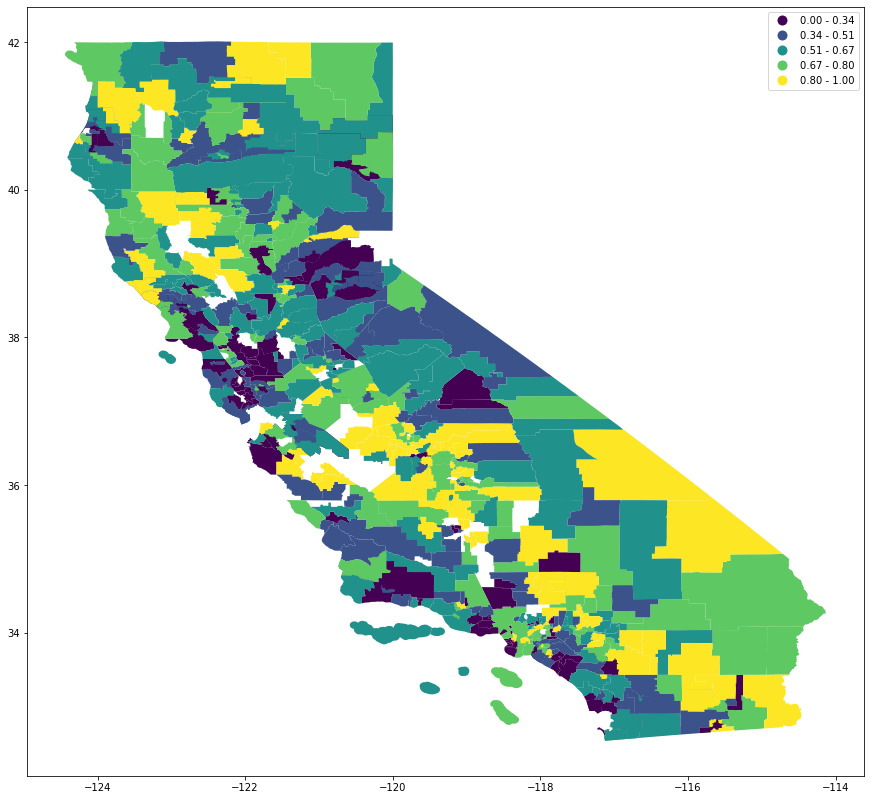

In [83]:
gdf1.plot(
    column='pct_frpm_by_age',
    legend=True,
    figsize=(15, 15),
    scheme="quantiles"
        )

## Unduplicated pupil count breakpoint groups

compare groups to state averages

In [ ]:
a1 = pandas.merge(dflcff, adistricts, how='left', left_on='Local Educational Agency', right_on='NAME')
# DELETE THIS LATER

In [84]:
df = a1

In [85]:
df['unduplicated_pupil_count'] = df['unduplicated_pupil_count'].astype(float)

In [86]:
df['treatment'] = (df.unduplicated_pupil_count >= 0.55) * 1
# creating dummy variable
df.head()

,District Code,Local Educational Agency,unduplicated_pupil_count,base_grant,supplemental_grant,concentration_grant,total_grants,cds,STATEFP,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,origin,ELSDLEA,SCSDLEA,treatment
0,61119,Alameda Unified,0.3486,"75,938,983","5,294,466",-,"82,158,116",01611190000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,0
1,61127,Albany City Unified,0.2833,"29,644,972","1,679,684",-,"31,352,540",01611270000000,06,01860,0601860,Albany City Unified,00,KG,12,G5420,None,E,4634305.0,9523833.0,+37.8906499,-122.3181164,"POLYGON ((-122.37312 37.88388, -122.37114 37.8...",unified,NaN,NaN,0
2,61143,Berkeley Unified,0.3519,"78,556,532","5,528,808",-,"89,369,621",01611430000000,06,04740,0604740,Berkeley Unified,00,KG,12,G5420,None,E,27095285.0,18715614.0,+37.8669717,-122.2991474,"POLYGON ((-122.36778 37.86673, -122.35671 37.8...",unified,NaN,NaN,0
3,61150,Castro Valley Unified,0.2904,"74,911,585","4,350,864",-,"79,554,607",01611500000000,06,07800,0607800,Castro Valley Unified,00,KG,12,G5420,None,E,177385526.0,4276387.0,+37.7196716,-122.0463454,"POLYGON ((-122.17916 37.80498, -122.17914 37.8...",unified,NaN,NaN,0
4,61168,Emery Unified,0.7953,"5,702,229","906,997","699,378","7,326,875",01611680000000,06,12630,0612630,Emery Unified,00,KG,12,G5420,None,E,3317306.0,2517858.0,+37.8399065,-122.2989635,"POLYGON ((-122.33014 37.84111, -122.32432 37.8...",unified,NaN,NaN,1


In [87]:
r3 = list(df['District Code'])
# list of districts to extract from performance data
mathpop = dfm[dfm['District Code'].isin(r3)]
# extracting from math
engpop = dfe[dfe['District Code'].isin(r3)]
# extracting from english
dffrpm['District Code'] = dffrpm.index
frpmpop = dffrpm[dffrpm['District Code'].isin(r3)]
frpmpop = frpmpop.reset_index(drop=True)
# extracting from frpm
engpop = engpop.rename(columns={'currstatus': 'ela_currstatus', 'priorstatus': 'ela_priorstatus', 'change' : 'ela_change'})
mathpop = mathpop.rename(columns={'currstatus': 'm_currstatus', 'priorstatus': 'm_priorstatus', 'change' : 'm_change'})
#renaming columns

In [88]:
df['total_grants'] = df['total_grants'].str.replace(',' , '').astype(float).astype(int)

In [89]:
df = df.merge(frpmpop, how='left', on='District Code')
# merging with frpm
df['per_capita_funds'] = df['total_grants'] / df['enrollment_by_age']
# inferring per capita

In [90]:
df.drop('STATEFP', axis=1, inplace=True)
df.drop('UNSDLEA', axis=1, inplace=True)
df.drop('GEOID', axis=1, inplace=True)
df.drop('NAME', axis=1, inplace=True)
df.drop('LSAD', axis=1, inplace=True)
df.drop('LOGRADE', axis=1, inplace=True)
df.drop('HIGRADE', axis=1, inplace=True)
df.drop('MTFCC', axis=1, inplace=True)
df.drop('SDTYP', axis=1, inplace=True)
df.drop('FUNCSTAT', axis=1, inplace=True)
df.drop('ALAND', axis=1, inplace=True)
df.drop('AWATER', axis=1, inplace=True)
df.drop('INTPTLAT', axis=1, inplace=True)
df.drop('INTPTLON', axis=1, inplace=True)
df.drop('origin', axis=1, inplace=True)
df.drop('ELSDLEA', axis=1, inplace=True)
df.drop('SCSDLEA', axis=1, inplace=True)

In [91]:
el_math = mathpop.loc[mathpop['studentgroup'] == 'english_learners']
el_eng = engpop.loc[engpop['studentgroup'] == 'english_learners']
# slicing only english learners
low_ses_math = mathpop.loc[mathpop['studentgroup'] == 'ses_disad']
low_ses_eng = engpop.loc[engpop['studentgroup'] == 'ses_disad']
# slicing low ses students
all_math = mathpop.loc[mathpop['studentgroup'] == 'all_students']
all_eng = engpop.loc[engpop['studentgroup'] == 'all_students']
# slicing all students
hisp_math = mathpop.loc[mathpop['studentgroup'] == 'hispanic']
hisp_eng = engpop.loc[engpop['studentgroup'] == 'hispanic']
# slicing only hispanic 
aa_math = mathpop.loc[mathpop['studentgroup'] == 'african_american']
aa_eng = engpop.loc[engpop['studentgroup'] == 'african_american']
# slicing only african american

In [94]:
el_df = df.merge(el_eng, how='left', on='District Code')
el_df = el_df.merge(el_math, how='left', on='District Code')
el_df.drop('districtname_y', axis=1, inplace=True)
el_df.drop('studentgroup_y', axis=1, inplace=True)
el_df.drop('countyname_y', axis=1, inplace=True)
el_df = el_df.rename(columns={'districtname_x': 'districtname', 'studentgroup_x': 'studentgroup', 'countyname_x': 'countyname'})
# creating english learners dataframe 

In [95]:
low_ses_df = df.merge(low_ses_eng, how='left', on='District Code')
low_ses_df = low_ses_df.merge(low_ses_math, how='left', on='District Code')
low_ses_df.drop('districtname_y', axis=1, inplace=True)
low_ses_df.drop('studentgroup_y', axis=1, inplace=True)
low_ses_df.drop('countyname_y', axis=1, inplace=True)
low_ses_df = low_ses_df.rename(columns={'districtname_x': 'districtname', 'studentgroup_x': 'studentgroup', 'countyname_x': 'countyname'})
# creating low SES dataframe 

In [96]:
all_df = df.merge(all_eng, how='left', on='District Code')
all_df = all_df.merge(all_math, how='left', on='District Code')
all_df.drop('districtname_y', axis=1, inplace=True)
all_df.drop('studentgroup_y', axis=1, inplace=True)
all_df.drop('countyname_y', axis=1, inplace=True)
all_df = all_df.rename(columns={'districtname_x': 'districtname', 'studentgroup_x': 'studentgroup', 'countyname_x': 'countyname'})
# creating low SES dataframe 

In [97]:
hisp_df = df.merge(hisp_eng, how='left', on='District Code')
hisp_df = hisp_df.merge(hisp_math, how='left', on='District Code')
hisp_df.drop('districtname_y', axis=1, inplace=True)
hisp_df.drop('studentgroup_y', axis=1, inplace=True)
hisp_df.drop('countyname_y', axis=1, inplace=True)
hisp_df = hisp_df.rename(columns={'districtname_x': 'districtname', 'studentgroup_x': 'studentgroup', 'countyname_x': 'countyname'})
# creating hispanic dataframe 

In [98]:
aa_df = df.merge(aa_eng, how='left', on='District Code')
aa_df = aa_df.merge(aa_math, how='left', on='District Code')
aa_df.drop('districtname_y', axis=1, inplace=True)
aa_df.drop('studentgroup_y', axis=1, inplace=True)
aa_df.drop('countyname_y', axis=1, inplace=True)
aa_df = aa_df.rename(columns={'districtname_x': 'districtname', 'studentgroup_x': 'studentgroup', 'countyname_x': 'countyname'})
# creating african ameriacn dataframe 

In [99]:
hisp_df

,District Code,Local Educational Agency,unduplicated_pupil_count,base_grant,supplemental_grant,concentration_grant,total_grants,cds,geometry,treatment,enrollment_by_age,free_count_by_age,frpm_count_by_age,pct_frpm_by_age,pct_free_by_age,per_capita_funds,districtname,studentgroup,ela_currstatus,ela_priorstatus,ela_change,countyname,m_currstatus,m_priorstatus,m_change
0,61119,Alameda Unified,0.3486,"75,938,983","5,294,466",-,82158116,01611190000000,None,0,11031,2953,3306,0.299701,0.267700,7447.930015,Alameda Unified,hispanic,5.0,0.9,4.1,Alameda,-24.4,-26.7,2.3
1,61127,Albany City Unified,0.2833,"29,644,972","1,679,684",-,31352540,01611270000000,"POLYGON ((-122.37312 37.88388, -122.37114 37.8...",0,3612,647,742,0.205426,0.179125,8680.105205,Albany City Unified,hispanic,25.6,28.9,-3.3,Alameda,-2.7,3.1,-5.8
2,61143,Berkeley Unified,0.3519,"78,556,532","5,528,808",-,89369621,01611430000000,"POLYGON ((-122.36778 37.86673, -122.35671 37.8...",0,10022,2758,3153,0.314608,0.275195,8917.343943,Berkeley Unified,hispanic,-5.3,-20.7,15.5,Alameda,-22.6,-32.3,9.7
3,61150,Castro Valley Unified,0.2904,"74,911,585","4,350,864",-,79554607,01611500000000,"POLYGON ((-122.17916 37.80498, -122.17914 37.8...",0,9106,1811,2178,0.239183,0.198880,8736.504173,Castro Valley Unified,hispanic,-4.6,-2.0,-2.5,Alameda,-27.2,-29.7,2.5
4,61168,Emery Unified,0.7953,"5,702,229","906,997","699,378",7326875,01611680000000,"POLYGON ((-122.33014 37.84111, -122.32432 37.8...",1,727,515,583,0.801926,0.708391,10078.232462,Emery Unified,hispanic,-37.5,-39.2,1.6,Alameda,-71.5,-68.7,-2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,72728,Camptonville Elementary,0.6988,"420,692","58,796","31,299",537244,58727280000000,"POLYGON ((-121.16298 39.47496, -121.16254 39.4...",1,475,200,260,0.547368,0.421053,1131.040000,Camptonville Elementary,hispanic,NaN,NaN,NaN,Yuba,NaN,NaN,NaN
970,72736,Marysville Joint Unified,0.8168,"76,193,862","12,447,028","10,164,261",100261913,58727360000000,"POLYGON ((-121.63637 39.24608, -121.63629 39.2...",1,9963,7226,7833,0.786209,0.725284,10063.425976,Marysville Joint Unified,hispanic,-50.7,-52.6,1.9,Yuba,-71.5,-76.2,4.7
971,72744,Plumas Lake Elementary,0.3868,"10,261,440","793,825",-,11108901,58727440000000,"POLYGON ((-121.58904 38.99152, -121.58838 38.9...",0,1301,374,478,0.367410,0.287471,8538.740200,Plumas Lake Elementary,hispanic,5.2,-13.0,18.2,Yuba,-22.8,-44.6,21.8
972,72751,Wheatland,0.4783,"9,947,133","951,543",-,11234349,58727510000000,None,0,1364,457,644,0.472141,0.335044,8236.326246,Wheatland,hispanic,-12.7,-20.9,8.2,Yuba,-29.8,-36.0,6.2


In [100]:
low_ses_df.columns

Index(['District Code', 'Local Educational Agency', 'unduplicated_pupil_count',
       'base_grant', 'supplemental_grant', 'concentration_grant',
       'total_grants', 'cds', 'geometry', 'treatment', 'enrollment_by_age',
       'free_count_by_age', 'frpm_count_by_age', 'pct_frpm_by_age',
       'pct_free_by_age', 'per_capita_funds', 'districtname', 'studentgroup',
       'ela_currstatus', 'ela_priorstatus', 'ela_change', 'countyname',
       'm_currstatus', 'm_priorstatus', 'm_change'],
      dtype='object')

test scores = per capita (student) expenditures + (binaryxexpenditures)

In [111]:
results = smf.ols(formula='ela_currstatus ~ per_capita_funds*treatment', data=el_df,).fit()
# english learners
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         ela_currstatus   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     76.48
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           2.79e-43
Time:                        23:51:39   Log-Likelihood:                -3689.9
No. Observations:                 770   AIC:                             7388.
Df Residuals:                     766   BIC:                             7406.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [120]:
results = smf.ols(formula='m_currstatus ~ per_capita_funds*treatment', data=el_df,).fit()
# english learners
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           m_currstatus   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     64.75
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           2.56e-37
Time:                        23:54:30   Log-Likelihood:                -3929.2
No. Observations:                 770   AIC:                             7866.
Df Residuals:                     766   BIC:                             7885.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [112]:
results = smf.ols(formula='ela_currstatus ~ per_capita_funds*treatment', data=low_ses_df,).fit()
# socioeconomically disadvantaged 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         ela_currstatus   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     89.27
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           1.52e-50
Time:                        23:51:45   Log-Likelihood:                -4141.3
No. Observations:                 900   AIC:                             8291.
Df Residuals:                     896   BIC:                             8310.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [119]:
results = smf.ols(formula='m_currstatus ~ per_capita_funds*treatment', data=low_ses_df,).fit()
# low ses
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           m_currstatus   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     69.98
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           1.16e-40
Time:                        23:54:07   Log-Likelihood:                -4287.1
No. Observations:                 899   AIC:                             8582.
Df Residuals:                     895   BIC:                             8601.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [113]:
results = smf.ols(formula='ela_currstatus ~ per_capita_funds*treatment', data=all_df,).fit()
# all students
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         ela_currstatus   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     270.8
Date:                Tue, 02 Jun 2020   Prob (F-statistic):          5.70e-126
Time:                        23:51:55   Log-Likelihood:                -4396.3
No. Observations:                 925   AIC:                             8801.
Df Residuals:                     921   BIC:                             8820.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [118]:
results = smf.ols(formula='m_currstatus ~ per_capita_funds*treatment', data=all_df,).fit()
# all students
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           m_currstatus   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     237.2
Date:                Tue, 02 Jun 2020   Prob (F-statistic):          5.54e-114
Time:                        23:53:19   Log-Likelihood:                -4545.9
No. Observations:                 924   AIC:                             9100.
Df Residuals:                     920   BIC:                             9119.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [114]:
results = smf.ols(formula='ela_currstatus ~ per_capita_funds*treatment', data=hisp_df,).fit()
# hispanic
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         ela_currstatus   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     113.9
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           5.98e-62
Time:                        23:52:00   Log-Likelihood:                -3936.4
No. Observations:                 850   AIC:                             7881.
Df Residuals:                     846   BIC:                             7900.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [117]:
results = smf.ols(formula='m_currstatus ~ per_capita_funds*treatment', data=hisp_df,).fit()
# hispanic
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           m_currstatus   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     100.4
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           1.41e-55
Time:                        23:52:49   Log-Likelihood:                -4065.6
No. Observations:                 850   AIC:                             8139.
Df Residuals:                     846   BIC:                             8158.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [115]:
results = smf.ols(formula='ela_currstatus ~ per_capita_funds*treatment', data=aa_df,).fit()
# african american 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         ela_currstatus   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     59.14
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           5.75e-32
Time:                        23:52:08   Log-Likelihood:                -2049.3
No. Observations:                 429   AIC:                             4107.
Df Residuals:                     425   BIC:                             4123.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [116]:
results = smf.ols(formula='m_currstatus ~ per_capita_funds*treatment', data=aa_df,).fit()
# african american 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           m_currstatus   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     61.21
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           7.16e-33
Time:                        23:52:23   Log-Likelihood:                -2081.7
No. Observations:                 426   AIC:                             4171.
Df Residuals:                     422   BIC:                             4188.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [122]:
sns.regplot(x='ela_currstatus', y='per_capita_funds*treatment', data=all_df);
# control group - total grants' effects on current english scores

TypeError: can't multiply sequence by non-int of type 'str'

In [ ]:
sns.regplot(x='total_grants', y='ela_change', data=control);
# control group - total grant's effects on change in english score from previous year

In [ ]:
sns.regplot(x='total_grants', y='m_currstatus', data=control);
# control group - total grants' effects on current math scores

In [ ]:
sns.regplot(x='total_grants', y='m_change', data=control);
# control group - total grant's effects on change in math score from previous year

In [ ]:
sns.regplot(x='total_grants', y='ela_currstatus', data=treat);
# treatment group - total grants' effects on current english scores

In [ ]:
sns.regplot(x='total_grants', y='ela_change', data=treat);
# treatment group - total grant's effects on change in english score from previous year

In [ ]:
sns.regplot(x='total_grants', y='m_currstatus', data=treat);
# treatment group - total grants' effects on current english scores

In [ ]:
sns.regplot(x='total_grants', y='m_change', data=treat);
# treatment group - total grant's effects on change in math score from previous year

### To deal with dupes: need to remove duplicates NOT in these counties

In [ ]:
t2.loc[t2['district_name'] == 'Pioneer Union Elementary']

In [ ]:
gdf1.loc[gdf1['district_name'] == 'Pioneer Union Elementary']

In [ ]:
t2.loc[t2['district_name'] == 'Lakeside Union Elementary']

In [ ]:
t2.loc[t2['district_name'] == 'Jefferson Elementary']

In [ ]:
dupes

## Test Variables for merge with District Codes

In [ ]:
geot = set(adsgeo)
len(geot)
# There are no district codes in the geometries - must match by district name. 

In [ ]:
dffrpm

In [ ]:
frpmt = set(t1['District Code'])
len(frpmt)

In [ ]:
lcfft = set(dflcff['District Code'])
len(lcfft)

In [ ]:
elat = set(dfe['District Code'])
len(elat)

In [ ]:
matht = set(dfm['District Code'])
len(matht)
# lowest common denominator

In [ ]:
elat.difference(matht)

In [ ]:
d2 = lcfft.difference(matht)
d2

In [ ]:
d3 = lcfft.difference(elat)
d3

In [ ]:
drops = d2.intersection(d3)
len(drops)

In [ ]:
d2.difference(drops)

In [ ]:
drops = d2
len(drops)

In [ ]:
d4 = frpmt.difference(matht)
len(d4)

In [ ]:
d2.difference(d4)

In [ ]:
d3.difference(d4)

### d4 contains the list of districts to drop to merge all 4 datasets. 

In [ ]:
len(d4)

In [ ]:
d4

# Examining data

### State-level performance data

In [ ]:
ela_state

In [ ]:
math_state

In [ ]:
dfe = dfe.rename(columns={'currstatus': 'ela_currstatus',
                          'priorstatus': 'ela_priorstatus',
                          'change' : 'ela_change'
                         })
dfe
# dataframe english

In [ ]:
dfm = dfm.rename(columns={'currstatus': 'm_currstatus',
                          'priorstatus': 'm_priorstatus',
                          'change' : 'm_change'
                         })
dfm
# dataframe math

### Merging lcff and frpm (done)

In [ ]:
q1 = dflcff['District Code'].values
len(q1)

In [ ]:
q2 = t1['District Code'].values
len(q2)

In [ ]:
s1 = set(dflcff['District Code'])
len(s1)

In [ ]:
s2 = set(t6['District Code'])

In [ ]:
s3 = s2.difference(s1)
len(s3)

In [ ]:
s4 = s1.difference(s2)
len(s4)

In [ ]:
f1 = dflcff[~dflcff['District Code'].isin(s4)]
# slicing out matches from lcff
f2 = t1[~t1['District Code'].isin(s3)]
# slicing out matches from frpm
df2 = f1.merge(f2, on='District Code')
# merging lcff and frpm
df2 = df2.merge(adistricts, how='left', left_on='district_name', right_on='NAME')
df2 = geopandas.GeoDataFrame(df2)
# merging with geometries, converting to geodataframe

In [ ]:
df2
# need to clean this if we're going to use it
# have lcff and frpm as two geodataframes above

In [ ]:
df2.plot(
    column='base_grant',
    legend=True,
    figsize=(15, 15),
    scheme="quantiles"
        )

# WORKING CELLS: performance

In [ ]:
dfe2 = dfe[dfe['District Code'] !='70318']
dfe2
# inherent problem: after dropping extra district, still 5 extra rows?

In [ ]:
dfm.shape

In [ ]:
dfe.head(50)

In [ ]:
dfe2 = dfe
dfe2

In [ ]:
# Create a variable
mscore = []


for row in dfm['District Code'], dfm['studentgroup']:
    mscore.append(row)


dfe2['m_currstatus'] = mscore

# View the dataframe
dfe2

# cannot add (ignore index=True) to append line

In [ ]:
pdict = {}

In [ ]:
values = dfm.values
keys = mkey
for i in keys:
    for x in values:
        pdict[i] = x
pdict

In [ ]:
# Can I use the codes and groups to merge onto original dfe dataframe?
mdist = dfm['District Code']
mgroup = dfm['studentgroup']
mscore = dfm['m_currstatus']
mprio = dfm['m_priorstatus']
mchange = dfm['m_change']
mscores = list(zip(mdist, mgroup, mscore, mprio, mchange))
mscores

In [ ]:
edist = dfe['District Code']
egroup = dfe['studentgroup']
escore = dfe['ela_currstatus']
eprio = dfe['ela_priorstatus']
echange = dfe['ela_change']
escores = list(zip(edist, egroup, escore, eprio, echange))
escores

In [ ]:
result = pandas.merge([escores, mscores], right=edist, sort=False)

In [ ]:
scores = []
for row in dfm['m_currsrtatus']:
    scores.append(ignore_index=True)
    
dfe['m_currstatus'] = scores
dfe

In [ ]:
test = dfe.append(dfm, ignore_index=True)

In [ ]:
s3 = dfe.combine_first(dfm)
s3.head(200)

In [ ]:
dfe

In [ ]:
mscores = dfm.districtname, dfm.studentgroup, dfm.m_currstatus, dfm.m_priorstatus, dfm.m_change
mscores

In [ ]:
s2 = pandas.concat([dfe, dfm],
                   levels=[['studentgroup', 'districtname']],
                   axis=1)
s2

In [ ]:
s2 = pandas.concat([dfe, mscores],
                   axis=1,
                   levels=[['districtname', 'studentgroup',]],
                   ignore_index=True)
s2

In [ ]:
s1 = pandas.merge(dfe, dfm, how='inner', 
                  on=['District Code'], 
                  right_index=True)

In [ ]:
s1
# english groups got messed up here

In [ ]:
s1.drop('districtname_y', axis=1, inplace=True)
s1.drop('studentgroup_y', axis=1, inplace=True)
s1 = s1.rename(columns={'districtname_x': 'districtname',
                          'studentgroup_x': 'studentgroup',
                        })

In [ ]:
s2 = pandas.merge(s1, dflcff, how='left', on=['District Code'])
s2
# probably a better way to do this

In [ ]:
len(elat)

In [ ]:
len(matht)

In [ ]:
dflcff['District Code'].drop(, inplace=True)
dflcff

trying to make dictionary - this approach would require 34 dictionaries - 1 for every student group (17) in each subject (2: ela, math)

In [ ]:
# Create an empty list 
Row_list =[] 
  
# Iterate over each row 
for index, rows in ela.iterrows(): 
    # Create list for the current row 
    my_list = [rows.studentgroup, rows.currstatus, rows.priorstatus, rows.change, rows.currdenom] 
      
    # append the list to the final list 
    Row_list.append(my_list) 

    
Row_list

In [ ]:
pdict = dict(zip(ela.countyname, Row_list))
print(pdict)
# closer! only got one student group

In [ ]:
district_list = []
for index, rows in ela.iterrows():
    a_list = [rows.districtname]
    district_list.append(a_list)
    
district_list

In [ ]:
districts

In [ ]:
pdict ={} 
for key in districts: 
    for value in Row: 
        pdict[key] = value 
        Row.remove(value) 
        break  

In [ ]:
dflcff.drop(s3, inplace=True)
dflcff

### play cells

In [ ]:
i = ela.loc[ela['rtype'] == 'S']
o = i = pandas.concat([i.pop(x) for x in ['schoolname', 
                                      'cds']],
                  1)
o
# had to check this school's cds code to validate with another dataset

In [ ]:
mlist = []
for group in dfm['District Code']:
    mlist.append(dfm.studentgroup)
    for group in dfm['studentgroup']:
        mlist.append(dfm.m_currstatus)
mlist

In [ ]:
dfmm = dfm
dfm1 = pandas.concat([dfmm.pop(x) for x in ['District Code',
                                           'studentgroup',
                                           'currstatus',
                                           'priorstatus',
                                           'change',
                                          ]])

# Census Data

#### SCAG counties and their FIPS codes:
<br> Los Angeles (06037)<br> Orange (06059)<br> Riverside (06065)<br> San Bernardino (06071)<br> San Diego (06073)<br>Imperial (06025)<br> Ventura (06111)

In [123]:
ca = Community.from_census(state_fips='06')

C:\Users\fiend\Anaconda2\envs\capstone\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [124]:
ca.gdf['county'] = ca.gdf.geoid.str[:5]
# create counties variable

In [125]:
countymean = ca.gdf.dissolve(by='county', aggfunc='mean')

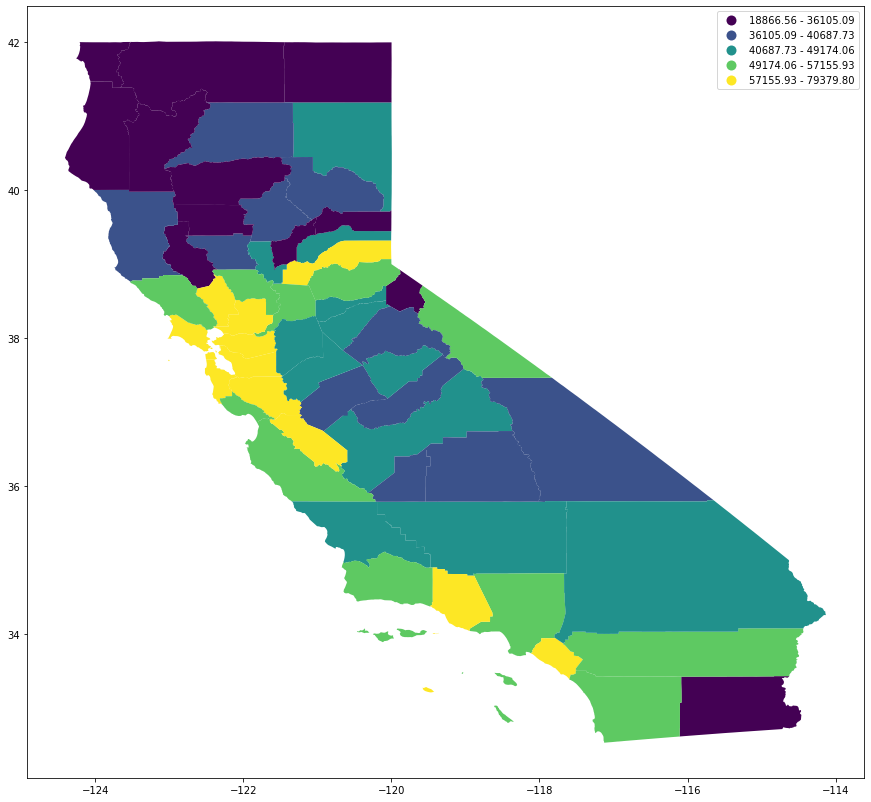

In [126]:
countymean.plot(column='median_household_income',
                legend=True,
                figsize=(15, 15),
                scheme="quantiles"
                
        )

In [127]:
countymean.head()

,geometry,n_mexican_pop,n_cuban_pop,n_puerto_rican_pop,n_total_housing_units,n_vacant_housing_units,n_occupied_housing_units,n_owner_occupied_housing_units,n_renter_occupied_housing_units,n_white_persons,n_nonhisp_white_persons,n_black_persons,n_nonhisp_black_persons,n_hispanic_persons,n_native_persons,n_hawaiian_persons,n_asian_indian_persons,n_chinese_persons,n_filipino_persons,n_japanese_persons,n_korean_persons,n_asian_persons,n_vietnamese_persons,n_white_age_distribution,n_white_under_15,n_white_over_60,n_white_over_65,n_black_age_distribution,n_black_under_15,n_black_over_60,n_black_over_65,n_hispanic_age_distribution,n_hispanic_under_15,n_hispanic_over_60,n_hispanic_over_65,n_native_age_distribution,n_native_under_15,n_native_over_60,n_native_over_65,n_asian_age_distribution,n_asian_under_15,n_total_pop,n_russian_pop,n_italian_pop,n_german_pop,n_irish_pop,n_foreign_born_pop,n_recent_immigrant_pop,n_naturalized_pop,n_age_5_older,n_other_language,n_limited_english,median_home_value,median_contract_rent,n_structures_30_old,n_occupied_housing_units_sample,n_household_recent_move,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_persons_over_25,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_female_over_16,n_female_labor_force,n_labor_force,n_unemployed_persons,n_employed_over_16,n_employed_professional,n_employed_manufacturing,n_employed_self_employed,n_civilians_over_16,n_veterans,n_civilians_16_64,n_disabled,median_household_income,n_total_households,n_white_households,n_black_households,n_hispanic_households,n_asian_households,per_capita_income,n_poverty_determined_persons,n_poverty_persons,n_poverty_over_65,n_poverty_determined_families,n_poverty_determined_white,n_poverty_white,n_poverty_determined_black,n_poverty_black,n_poverty_determined_native,n_poverty_native,n_poverty_determined_asian,n_poverty_asian,n_edu_college_greater,n_edu_hs_less,p_mexican_pop,p_cuban_pop,p_puerto_rican_pop,p_russian_pop,p_italian_pop,p_german_pop,p_irish_pop,p_foreign_born_pop,p_recent_immigrant_pop,p_naturalized_pop,p_other_language,p_limited_english,n_housing_units_multiunit_structures_denom,n_total_housing_units_sample,p_vacant_housing_units,p_owner_occupied_units,p_structures_30_old,p_household_recent_move,p_persons_under_18,p_persons_over_60,p_persons_over_75,p_married,p_widowed_divorced,p_female_headed_families,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,p_native_persons,p_asian_persons,p_hawaiian_persons,p_asian_indian_persons,p_chinese_persons,p_filipino_persons,p_japanese_persons,p_korean_persons,p_vietnamese_persons,p_white_under_15,p_white_over_60,p_white_over_65,p_black_under_15,p_black_over_60,p_black_over_65,p_hispanic_under_15,p_hispanic_over_60,p_hispanic_over_65,p_native_under_15,p_native_over_60,p_native_over_65,p_asian_under_15,p_edu_hs_less,p_edu_college_greater,p_unemployment_rate,p_employed_professional,p_employed_manufacturing,p_employed_self_employed,p_veterans,p_disabled,p_poverty_rate,p_poverty_rate_over_65,p_poverty_rate_white,p_poverty_rate_black,p_poverty_rate_native,p_poverty_rate_asian,year,median_income_asianhh,median_income_blackhh,median_income_hispanichh,median_income_whitehh,n_asian_over_60,n_asian_over_65,n_civilians_over_18,n_german_born_pop,n_housing_units_multiunit_structures,n_irish_born_pop,n_italian_born_pop,n_poverty_determined_hispanic,n_poverty_families_children,n_poverty_hispanic,n_russian_born_pop,n_scandaniavian__born_pop,n_scandaniavian_pop,p_asian_over_60,p_asian_over_65,p_german_born_pop,p_housing_units_multiunit_structures,p_irish_born_pop,p_italian_born_pop,p_poverty_rate_children,p_poverty_rate_hispanic,p_russian_born_pop,p_scandanavian_born_pop,p_scandanavian_pop,n_total_pop_sample,p_female_labor_force,p_black_persons
county,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [ ]:
ca2 = ca.cluster(method='kmeans', n_clusters=5, columns=['median_household_income', 'n_edu_hs_less'] )
ca2.gdf[ca2.gdf.year==2010].plot(column='kmeans',
                                 figsize=(15, 15),
                                 legend=True
                                )

In [ ]:
from segregation.aspatial import GiniSeg
index = GiniSeg(scag.gdf, 'n_mexican_pop', 'n_total_pop')
type(index)

# MERGE SCHOOL DISTRICTS WITH CENSUS DATA

In [ ]:
ca.plot(
    column='median_household_income',
    legend=True,
    figsize=(15, 15),
    scheme="quantiles"
        )

In [ ]:
plot(cacom, 'median_household_income')

In [ ]:
scag = Community.from_census(county_fips=['06025', '06037', '06059', '06071', '06111', '06073', '06065'])

In [ ]:
scag.gdf.plot(
    column = 'median_household_income'
            )

In [ ]:
rivco = Community.from_census(county_fips=['06065'])

In [ ]:
orangeco = Community.from_census(county_fips=['06059'])

In [ ]:
laco = Community.from_census(county_fips=['06037'])

In [ ]:
sbco = Community.from_census(county_fips=['06071'])

In [ ]:
sdco = Community.from_census(county_fips=['06073'])

In [ ]:
f, ax = plt.subplots(1, figsize=(30, 30))
ax = rivco.gdf[rivco.gdf.year==2010].plot('p_poverty_rate_over_65', axes=ax)
plt.show()

# change gdf, variable, and year

### This 'plot' function will produce three maps, one from each of the census data years. We can use it to pass in communities and a specific variable to provide a preliminary view of changes over 30 years.

In [ ]:
def plot(community, column):
    fig, axs = plt.subplots(1,3, figsize=(20,20))
    axs=axs.flatten()
    
    community.gdf[community.gdf.year==1990].dropna(subset=[column]).plot(column=column, scheme='quantiles', cmap='Greens', k=7, ax=axs[0])
    axs[0].axis('off')
    axs[0].set_title('1990')

    community.gdf[community.gdf.year==2000].dropna(subset=[column]).plot(column=column, scheme='quantiles', cmap='Greens', k=7, ax=axs[1])
    axs[1].axis('off')
    axs[1].set_title('2000')

    community.gdf[community.gdf.year==2010].dropna(subset=[column]).plot(column=column, scheme='quantiles', cmap='Greens', k=7, ax=axs[2])
    axs[2].axis('off')
    axs[2].set_title('2010')

In [ ]:
datasets.codebook()

### Variables of interest from census:
#### economic indicators
median_household_income <br>
median_home_value OR median_contract_rent<br>
median_income_whitehh<br>
median_income_blackhh<br>
median_income_hispanichh<br>
n_edu_college_greater - persons with at least 4-year degree (also available as %)<br>
n_edu_hs_less - persons with less than high school (also available as %)<br>

#### demographic indicators
n_recent_immigrant_pop (within the last 10 years)<br>
n_limited_english OR n_other_language<br>
n_hispanic_persons<br>
n_black_persons<br>
n_white_persons

## Alternative community construction

Can also construct communities from longitudinal tract database (ltdb)

In [ ]:
datasets.msas()[datasets.msas().name.str.startswith('Riverside')]

In [ ]:
datasets.msas()[datasets.msas().name.str.startswith('Orange')]

In [ ]:
datasets.msas()[datasets.msas().name.str.startswith('San')]

In [ ]:
LA = Community.from_ltdb(msa_fips='31080')

In [ ]:
SD = Community.from_ltdb(msa_fips='41740')

In [ ]:
riverside = Community.from_ltdb(msa_fips='40140')